### 🎯 **Goal of Softmax Regression on MNIST**

* **Problem Type:** Multi-class classification (10 classes: digits 0–9).
* **Objective:** Learn a **linear mapping + softmax** that predicts which digit an image belongs to.

  * It’s the **baseline model** for multi-class classification.
  * It tests if our data pipeline + math (softmax + cross-entropy) are implemented correctly.
  * Gives a benchmark (\~92% accuracy) before moving to deeper models like MLPs or CNNs.

Think of it as:
👉 "Given a handwritten digit image, can my model correctly classify it into one of the 10 categories using just a linear transformation + softmax?"


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import tqdm

### Data prep

In [22]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [23]:
print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}")
print(f"X size: {X.size}")
print(f"y size: {y.size}")

X shape: (70000, 784)
y shape: (70000,)
X size: 54880000
y size: 70000


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) 

In [25]:
print(f"X train : {len(X_train)}")
print(f"y train : {len(y_train)}")
print(f"y test : {len(X_test)}")
print(f"y test : {len(y_test)}")

X train : 56000
y train : 56000
y test : 14000
y test : 14000


### Visualize

In [26]:
X_train_reshaped = X_train.values.reshape(-1,28,28)
y_train_labels = y_train.values

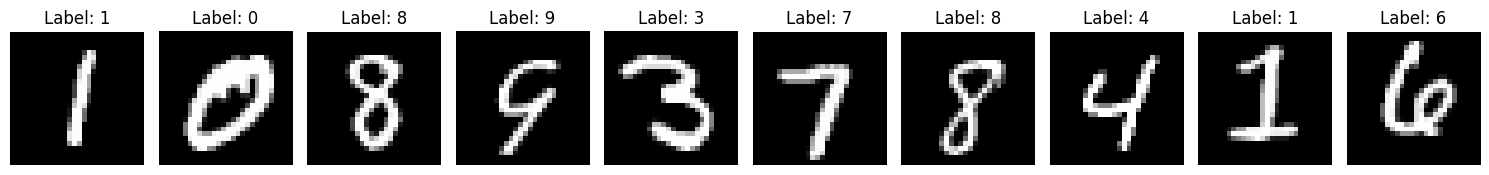

In [27]:
def visualize_images(images, labels, num_images = 10):
    """Args:
        images (np.ndarray): The dataset of images (e.g., X_train_reshaped).
        labels (np.ndarray): The corresponding labels (e.g., y_train_labels).
        num_images (int): The number of images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize = (15,3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')

        # Set the title to the corresponding label
        ax.set_title(f'Label: {labels[i]}')

        # Turn off the axes for a cleaner look
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(X_train_reshaped, y_train_labels, num_images=10)

In [30]:
from tqdm import tqdm

In [32]:
class MNISTCLASSIFICATION:
    """
    A simple two layer neural network for MNIST classifiation
    """

    def __init__(self,input_size,hidden_size, output_size):
        """
        Initializes the weights and biases of the neural network.

        Args:
            input_size (int): The number of features in the input data (e.g., 784 for MNIST).
            hidden_size (int): The number of neurons in the hidden layer.
            output_size (int): The number of classes (e.g., 10 for digits 0-9).
        """
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1,hidden_size))

        self.W2 = np.random.randn(hidden_size,output_size)
        self.b2 = np.zeros((1, output_size))
    
    def relu(self,z):
        ### ReLU activation function
        return np.max(0,z)
    def relu_derivative(self, z):
        """
        Computes the derivative of the ReLU function.
        """
        return (z > 0).astype(float)
    
    def softmax(self,z):
        exp_z = np.exp(z- np.max(z, axis = 1,keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def forward(self,X):
        # layer 1
        Z1 = np.dot(X,self.W1) + self.b1
        A1 = self.relu(Z1)

        #layer 2
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.softmax(Z2)

        return Z1, A1, Z2
    
    def compute_loss(self, y, y_hat):
        """
        Computes the cross-entropy loss.
        """
        m = y.shape[0]
        # Cross-entropy loss formula
        loss = -np.sum(y * np.log(y_hat + 1e-8)) / m
        return loss
    
    def backward(self, X, y, Z1, A1, A2):
        """
        Performs the backward pass to compute gradients.
        
        Args:
            X (np.ndarray): The input data.
            y (np.ndarray): The true labels (one-hot encoded).
            Z1, A1, A2: Outputs from the forward pass.
            
        Returns:
            tuple: Gradients of the loss with respect to W1, b1, W2, and b2.
        """
        m = X.shape[0]

        #o/p gradients
    # Output layer gradients
        dZ2 = A2 - y  # Simple and elegant derivative for Softmax with Cross-Entropy
        dW2 = np.dot(A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Hidden layer gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        """
        Updates the weights and biases using gradient descent.
        """
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    
    def train(self,X_train,y_train,epochs,learning_rate):
        # One-hot encode the labels
        num_classes = self.W2.shape[1]
        y_train_one_hot = np.eye(num_classes)[y_train.astype(int)]
        for epoch in tqdm(range(epochs), desc="Training Progress"):
            # Forward pass
            Z1, A1, A2 = self.forward(X_train)

            # Compute loss
            loss = self.compute_loss(y_train_one_hot, A2)
            
            # Backward pass (compute gradients)
            dW1, db1, dW2, db2 = self.backward(X_train, y_train_one_hot, Z1, A1, A2)

            # Update parameters
            self.update_parameters(dW1, db1, dW2, db2, learning_rate)

            # Print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
    

In [33]:
# Let's define the model parameters
input_size = 784
hidden_size = 128
output_size = 10
epochs = 50
learning_rate = 0.01

# Instantiate the model
model = MNISTCLASSIFICATION(input_size, hidden_size, output_size)

# Run the training loop
print("Starting training...")
model.train(X_train.values, y_train.values, epochs, learning_rate)
print("Training finished!")

Starting training...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


TypeError: only integer scalar arrays can be converted to a scalar index